In [23]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
accepted = pd.read_csv("Lending_Club_Accepted_2014_2018.csv", low_memory=False)

In [239]:
accepted36 = accepted[accepted["term"] == " 36 months"]
accepted60 = accepted[accepted["term"] == " 60 months"]

In [270]:
sdart60 = pd.read_csv("sdart_2022_2_b.csv", low_memory=False)
sdart60 = sdart60[sdart60["Credit Score"] >= 660]
sdart36 = pd.read_csv("sdart_2022_1_a3.csv", low_memory=False)
sdart36 = sdart36[sdart36["Credit Score"] >= 660]
eart60 = pd.read_csv("eart_2022_3a_c.csv", low_memory=False)
eart60 = eart60[eart60["Credit Score"] >= 660]

12853.865329269176


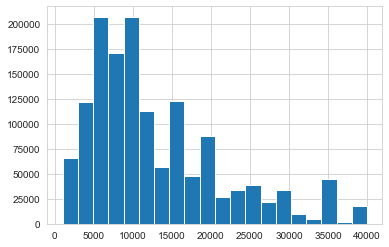

In [242]:
plt.hist(accepted36["loan_amnt"], bins=20)
print(accepted36["loan_amnt"].mean())

11.843926472938525


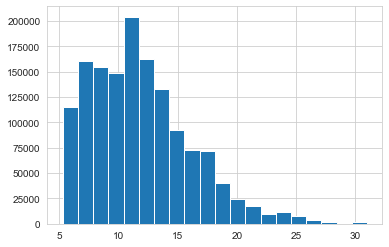

In [243]:
plt.hist(accepted36["int_rate"], bins=20)
print(accepted36["int_rate"].mean())

20829.549052758117


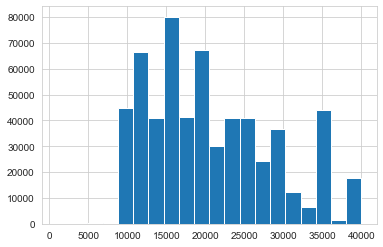

In [244]:
plt.hist(accepted60["loan_amnt"], bins=20)
print(accepted60["loan_amnt"].mean())

15.792035210159138


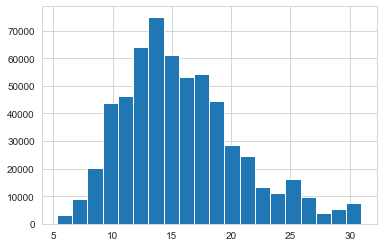

In [245]:
plt.hist(accepted60["int_rate"], bins=20)
print(accepted60["int_rate"].mean())

30264.736031879103


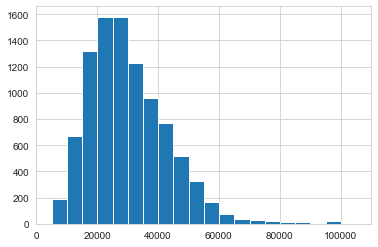

In [246]:
plt.hist(sdart36["Original Balance"], bins=20)
print(sdart36["Original Balance"].mean())

11.062779991610585


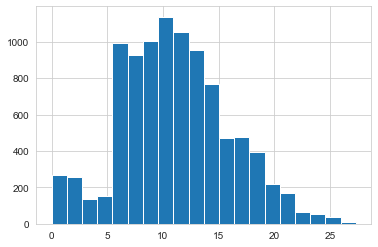

In [247]:
plt.hist(sdart36["APR"], bins=20)
print(sdart36["APR"].mean())

28701.820661019072


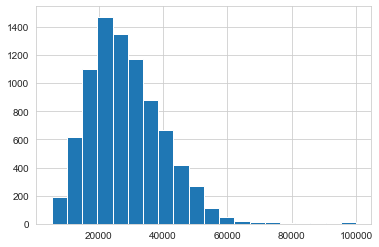

In [248]:
plt.hist(sdart60["Original Balance"], bins=20)
print(sdart60["Original Balance"].mean())

11.683049755399296


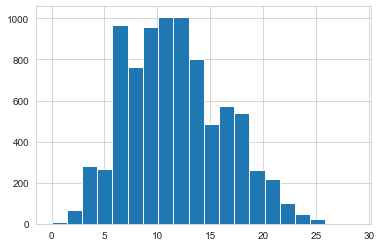

In [249]:
plt.hist(sdart60["APR"], bins=20)
print(sdart60["APR"].mean())

24471.706837398367


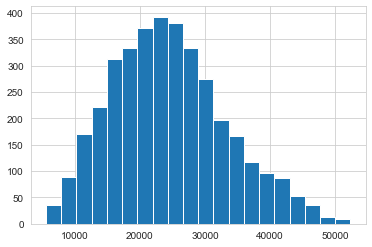

In [250]:
plt.hist(eart60["Original Balance"], bins=20)
print(eart60["Original Balance"].mean())

11.360455284552586


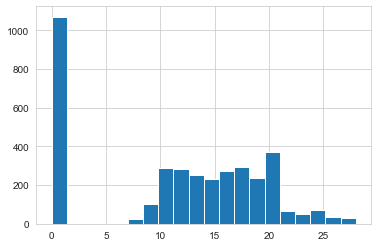

In [251]:
plt.hist(eart60["APR"], bins=20)
print(eart60["APR"].mean())

In [14]:
accepted36["WAL"] = (36*accepted36["installment"] - accepted36["loan_amnt"])/(accepted36["loan_amnt"]*accepted36["int_rate"]*0.01)
accepted60["WAL"] = (60*accepted60["installment"] - accepted60["loan_amnt"])/(accepted60["loan_amnt"]*accepted60["int_rate"]*0.01)

In [15]:
accepted36["WAL"].median()
#ACAR 2021-2, CPS 2021-C, DRIVE 2021-3, WLAKE 2021-3, TAST 2022-1A

1.6271316477768087

In [16]:
accepted60["WAL"].median()
#SDART 2022-2 B, VEROS 2020-1 D, FCAT 2021-2 B  

2.8493662441627747

In [271]:
sum((sdart60["APR"]*sdart60["Original Balance"])/sum(sdart60["Original Balance"]))

11.455634099474583

In [272]:
sum((accepted60["int_rate"]*accepted60["loan_amnt"])/sum(accepted60["loan_amnt"]))

15.715420299178371

10.965908243812528

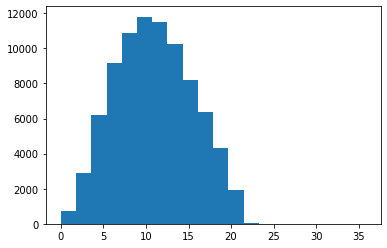

In [183]:
plt.hist(sdart60["Payment to Income Ratio"], bins=20)
sdart60["Payment to Income Ratio"].mean()

(array([3.5960e+03, 1.5347e+04, 2.2678e+04, 2.1776e+04, 1.4591e+04,
        6.1970e+03, 5.8000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e-02, 3.5860e+00, 7.1620e+00, 1.0738e+01, 1.4314e+01,
        1.7890e+01, 2.1466e+01, 2.5042e+01, 2.8618e+01, 3.2194e+01,
        3.5770e+01]),
 <a list of 10 Patch objects>)

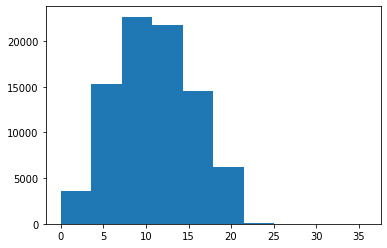

In [184]:
plt.hist(sdart60["Payment to Income Ratio"], bins=10)

In [273]:
def features(df):
    df["delinq_2yrs"] = 24*(df["Pay History"].str.count("3") + df["Pay History"].str.count("6") + df["Pay History"].str.count("9"))/df["Age"]
    df["installment"] = df["APR"]*df["Original Balance"]/1200
    df["annual_inc"] = 1200*df["installment"]/df["Payment to Income Ratio"]
    df["logged_inc"] = np.log(df["annual_inc"])
    df["Weight"] = (df["APR"]*df["Original Balance"])/sum(df["Original Balance"])
    df = df[df["annual_inc"] != 0]
    df["rPH"] = df.loc[:,"Pay History"].apply(lambda x: x[::-1])
    df["Dummy"] = 0
    df["mths_since_last_delinq_3"] = df["rPH"].str.find("3")
    df["mths_since_last_delinq_6"] = df["rPH"].str.find("6")
    df["mths_since_last_delinq_9"] = df["rPH"].str.find("9")
    df["mths_since_last_delinq"] = df[["mths_since_last_delinq_3", "mths_since_last_delinq_6", "mths_since_last_delinq_9", "Dummy"]].max(axis=1)
    df["int_rate"] = df["APR"]
    df["loan_amnt"] = df["Original Balance"]
    df["syn_payment"] = (df["Original Balance"] - df["Current Balance"])/df["Age"]
    return df

In [261]:
sdart60_plus = features(sdart60)
sdart36_plus = features(sdart36)
eart60_plus = features(eart60)

In [262]:
sdart60_rates = np.array(sdart60["APR"])
eart60_rates = np.array(eart60["APR"])
sdart36_rates = np.array(sdart36["APR"])
accepted60_rates = np.array(accepted60["int_rate"])
accepted36_rates = np.array(accepted36["int_rate"])

accepted36_size = np.array(accepted36["loan_amnt"])
sdart36_size = np.array(sdart36_plus["loan_amnt"])
accepted60_size = np.array(accepted60["loan_amnt"])
sdart60_size = np.array(sdart60_plus["loan_amnt"])
eart60_size = np.array(eart60_plus["loan_amnt"])

accepted36_inc = np.array(accepted36["annual_inc"])
sdart36_inc = np.array(sdart36_plus["annual_inc"])
accepted60_inc = np.array(accepted60["annual_inc"])
sdart60_inc = np.array(sdart60_plus["annual_inc"])
eart60_inc = np.array(eart60_plus["annual_inc"])

accepted36_c = np.array(accepted36["fico_range_low"])
sdart36_c = np.array(sdart36["Credit Score"])
accepted60_c = np.array(accepted60["fico_range_low"])
sdart60_c = np.array(sdart60["Credit Score"])
eart60_c = np.array(eart60["Credit Score"])

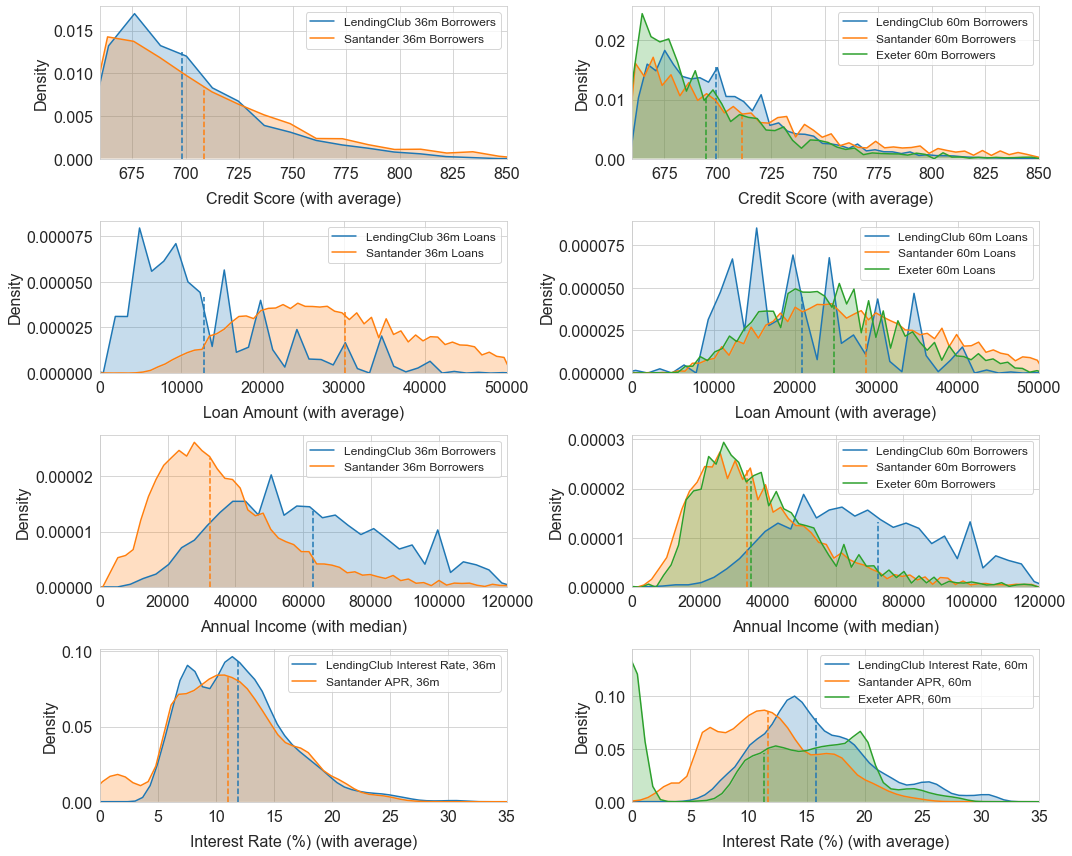

In [267]:
sns.set_style("whitegrid")

fig=plt.figure(figsize=(15,12))

ax1=fig.add_subplot(421) 
sns.kdeplot(accepted36_c, cut = 850, clip = (660, 850), shade=True, bw=0.8, label = "LendingClub 36m Borrowers")
ax1.axvline(x=accepted36_c.mean(), c='C0', linestyle='--', ymax=0.7)
sns.kdeplot(sdart36_c, cut = 850, clip = (660, 850), shade=True, bw=0.8, label = "Santander 36m Borrowers")
ax1.axvline(x=sdart36_c.mean(), c='C1', linestyle='--', ymax=0.47)
ax1.tick_params(labelsize=16)
ax1.set_xlabel("Credit Score (with average)", fontsize = 16, labelpad= 10)
ax1.set_ylabel("Density", fontsize = 16)
ax1.legend(fontsize = 12)
ax1.set_xlim(660, 850)


ax2=fig.add_subplot(422)
sns.kdeplot(accepted60_c, cut = 850, clip = (660, 850), shade=True, bw=0.2, label = "LendingClub 60m Borrowers")
ax2.axvline(x=accepted60_c.mean(), c='C0', linestyle='--', ymax=0.6)
sns.kdeplot(sdart60_c, cut = 850, clip = (660, 850), shade=True, bw=0.2, label = "Santander 60m Borrowers")
ax2.axvline(x=sdart60_c.mean(), c='C1', linestyle='--', ymax=0.3)
sns.kdeplot(eart60_c, cut = 850, clip = (660, 850), shade=True, bw=0.2, label = "Exeter 60m Borrowers")
ax2.axvline(x=eart60_c.mean(), c='C2', linestyle='--', ymax=0.4)
ax2.tick_params(labelsize=16)
ax2.set_xlabel("Credit Score (with average)", fontsize = 16, labelpad= 10)
ax2.set_ylabel("Density", fontsize = 16)
ax2.legend(fontsize = 12)
ax2.set_xlim(660, 850)

ax3=fig.add_subplot(423) 
sns.kdeplot(accepted36_size, cut = 50000, clip = (0, 50000), shade=True, bw=1.5, label = "LendingClub 36m Loans")
ax3.axvline(x=accepted36_size.mean(), c='C0', linestyle='--', ymax=0.5)
sns.kdeplot(sdart36_size, cut = 50000, clip = (0, 50000), shade=True, bw=0.7, label = "Santander 36m Loans")
ax3.axvline(x=sdart36_size.mean(), c='C1', linestyle='--', ymax=0.4)
ax3.tick_params(labelsize=16)
ax3.set_xlabel("Loan Amount (with average)", fontsize = 16, labelpad= 10)
ax3.set_ylabel("Density", fontsize = 16)
ax3.legend(fontsize = 12)
ax3.set_xlim(0, 50000)


ax4=fig.add_subplot(424) 
sns.kdeplot(accepted60_size, cut = 50000, clip = (0, 50000), shade=True, bw=1.5, label = "LendingClub 60m Loans")
ax4.axvline(x=accepted60_size.mean(), c='C0', linestyle='--', ymax=0.5)
sns.kdeplot(sdart60_size, cut = 50000, clip = (0, 50000), shade=True, bw=0.7, label = "Santander 60m Loans")
ax4.axvline(x=sdart60_size.mean(), c='C1', linestyle='--', ymax=0.4)
sns.kdeplot(eart60_size, cut = 50000, clip = (0, 50000), shade=True, bw=0.7, label = "Exeter 60m Loans")
ax4.axvline(x=eart60_size.mean(), c='C2', linestyle='--', ymax=0.45)
ax4.tick_params(labelsize=16)
ax4.set_xlabel("Loan Amount (with average)", fontsize = 16, labelpad= 10)
ax4.set_ylabel("Density", fontsize = 16)
ax4.legend(fontsize = 12)
ax4.set_xlim(0, 50000)

ax5=fig.add_subplot(425) 
sns.kdeplot(accepted36_inc, cut = 120000, clip = (0, 120000), shade=True, bw=1.5, label = "LendingClub 36m Borrowers")
ax5.axvline(x=np.median(accepted36_inc), c='C0', linestyle='--', ymax=0.5)
sns.kdeplot(sdart36_inc, cut = 120000, clip = (0, 120000), shade=True, bw=0.7, label = "Santander 36m Borrowers")
ax5.axvline(x=np.median(sdart36_inc), c='C1', linestyle='--', ymax=0.85)
ax5.tick_params(labelsize=16)
ax5.set_xlabel("Annual Income (with median)", fontsize = 16, labelpad= 10)
ax5.set_ylabel("Density", fontsize = 16)
ax5.legend(fontsize = 12)
ax5.set_xlim(0, 120000)

ax6=fig.add_subplot(426)
sns.kdeplot(accepted60_inc, cut = 120000, clip = (0, 120000), shade=True, bw=1.5, label = "LendingClub 60m Borrowers")
ax6.axvline(x=np.median(accepted60_inc), c='C0', linestyle='--', ymax=0.43)
sns.kdeplot(sdart60_inc, cut = 120000, clip = (0, 120000), shade=True, bw=0.7, label = "Santander 60m Borrowers")
ax6.axvline(x=np.median(sdart60_inc), c='C1', linestyle='--', ymax=0.77)
sns.kdeplot(eart60_inc, cut = 120000, clip = (0, 120000), shade=True, bw=0.7, label = "Exeter 60m Borrowers")
ax6.axvline(x=np.median(eart60_inc), c='C2', linestyle='--', ymax=0.7)
ax6.tick_params(labelsize=16)
ax6.set_xlabel("Annual Income (with median)", fontsize = 16, labelpad= 10)
ax6.set_ylabel("Density", fontsize = 16)
ax6.legend(fontsize = 12)
ax6.set_xlim(0, 120000)

ax7=fig.add_subplot(427) 
sns.kdeplot(accepted36_rates, cut = 35, clip = (-2, 35), shade=True, bw=0.8, label = "LendingClub Interest Rate, 36m")
ax7.axvline(x=accepted36_rates.mean(), c='C0', linestyle='--', ymax=0.93)
sns.kdeplot(sdart36_rates, cut = 35, clip = (-2, 35), shade=True, bw=0.8, label = "Santander APR, 36m")
ax7.axvline(x=sdart36_rates.mean(), c='C1', linestyle='--', ymax=0.83)
ax7.tick_params(labelsize=16)
ax7.set_xlabel("Interest Rate (%) (with average)", fontsize = 16, labelpad= 10)
ax7.set_ylabel("Density", fontsize = 16)
ax7.legend(fontsize = 12)
ax7.set_xlim(0, 35)

ax8=fig.add_subplot(428) 
sns.kdeplot(accepted60_rates, cut = 35, clip = (-2, 35), shade=True, bw=0.8, label = "LendingClub Interest Rate, 60m")
ax8.axvline(x=accepted60_rates.mean(), c='C0', linestyle='--', ymax=0.55)
sns.kdeplot(sdart60_rates, cut = 35, clip = (-2, 35), shade=True, bw=0.8, label = "Santander APR, 60m")
ax8.axvline(x=sdart60_rates.mean(), c='C1', linestyle='--', ymax=0.59)
sns.kdeplot(eart60_rates, cut = 35, clip = (-2, 35), shade=True, bw=0.8, label = "Exeter APR, 60m")
ax8.axvline(x=eart60_rates.mean(), c='C2', linestyle='--', ymax=0.32)
ax8.tick_params(labelsize=16)
ax8.set_xlabel("Interest Rate (%) (with average)", fontsize = 16, labelpad= 10)
ax8.set_ylabel("Density", fontsize = 16)
ax8.legend(fontsize = 12)
ax8.set_xlim(0, 35)

fig.tight_layout()

plt.show()

fig.savefig("AllComps.png")

In [344]:
y = sdart60["int_rate"]
sdart60["dti"] = sdart60["loan_amnt"]/sdart60["annual_inc"]
sdart60["ldti"] = np.log(sdart60["dti"])
x = sdart60[["ldti", "fico", "logged_inc", "delinq_2yrs", "mths_since_last_delinq"]]
model_sdart60 = sm.WLS(y, x, weights=sdart60["Weight"]).fit()


print(mean_squared_error(y, model_sdart60.predict(x))**(1/2))
model_sdart60.summary()

4.968619551915252


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   0.925
Model:                            WLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.813e+05
Date:                Thu, 21 Jul 2022   Prob (F-statistic):                        0.00
Time:                        21:38:15   Log-Likelihood:                     -2.2301e+05
No. Observations:               73906   AIC:                                  4.460e+05
Df Residuals:                   73901   BIC:                                  4.461e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
ldti                      -2.4799      0.043    -57.537      0.000      -2.564      -2.395
fico                      -0.0127      0.000    -39.325      0.000      -0.013      -0.012
logged_inc                 2.1348      0.019    113.182      0.000       2.098       2.172
delinq_2yrs                0.2128      0.006     33.154      0.000       0.200       0.225
mths_since_last_delinq     0.0182      0.002      7.285      0.000       0.013       0.023
==============================================================================
Omnibus:                      890.768   Durbin-Watson:                   0.453
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              927.223
Skew:                           0.265   Prob(JB):                    4.53e-202
Kurtosis:                       3.144   Cond. No.                     1.54e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
x = sdart60[["loan_amnt", "fico", "loan_age_in_months", "annual_inc", "logged_inc", "delinq_2yrs", "mths_since_last_delinq"]]

In [312]:
x = sdart60[["loan_amnt", "fico", "annual_inc", "delinq_2yrs", "mths_since_last_delinq", "syn_payment"]]
y = sdart60["int_rate"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5)
rf = RandomForestRegressor(n_estimators = 100, max_features = 3, random_state=7, oob_score=True, max_depth=20).fit(x_train, y_train)
score = rf.score(x_train, y_train)
preds = rf.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("OOB Score: ", rf.oob_score_)
print("R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

C:\Users\Michael\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\Michael\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link 

OOB Score:  0.3571606683643199
R^2 Score:  0.7116914473462426
MSE:  18.310641973904012
RMSE:  9.155320986952006


In [ ]:
x = sdart60[["loan_amnt", "fico", "annual_inc", "delinq_2yrs", "mths_since_last_delinq", "syn_payment"]]
y = sdart60["int_rate"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)
grid = { 
    'n_estimators': [100, 200, 500],
    'max_depth' : [5,8,10,15],
    'eta' : [0.001, 0.005, 0.01, 0.1],
    'grow_policy' : ['depthwise', 'lossguide']
}

model = xgb.XGBRegressor()

xgbr_cv = GridSearchCV(estimator=model, param_grid=grid, cv=5)
xgbr_cv.fit(x_train, y_train)
res = xgbr_cv.best_params_
print(res)
xgbr = xgb.XGBRegressor(n_estimators=res["n_estimators"], max_depth=res["max_depth"], eta=res["eta"], grow_policy=res["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr.score(x_train, y_train)
preds = xgbr.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

In [332]:
accepted60_sliced = accepted60[["int_rate", "loan_amnt", "fico_range_low", "annual_inc", "delinq_2yrs", "mths_since_last_delinq"]]
accepted60_sliced = accepted60_sliced.dropna()

In [335]:
x = sdart60[["loan_amnt", "fico", "annual_inc", "delinq_2yrs", "mths_since_last_delinq"]]
y = sdart60["int_rate"]

xa = accepted60_sliced[["loan_amnt", "fico_range_low", "annual_inc", "delinq_2yrs", "mths_since_last_delinq"]]
ya = accepted60_sliced["int_rate"]

res = {'n_estimators': 400, 'max_depth': 5, 'grow_policy': 'depthwise', 'eta': 0.01}
xgbr = xgb.XGBRegressor(n_estimators=res["n_estimators"], max_depth=res["max_depth"], eta=res["eta"], grow_policy=res["grow_policy"], eval_metric='rmse').fit(x, y)
accepted60_preds = xgbr.predict(xa)
accepted60_mse = mean_squared_error(ya, accepted60_preds)
score = xgbr.score(x, y)
scoret = xgbr.score(xa, ya)
print("Training R^2 Score: ", score)
print("Testing R^2 Score: ", scoret)
print("MSE: ", accepted60_mse)
print("RMSE: ", accepted60_mse**(1/2.0))

Training R^2 Score:  0.3907536683112496
Testing R^2 Score:  -0.0141911482966115
MSE:  24.114005055776005
RMSE:  4.910601292690744


In [258]:
sdart60["loan_age_in_months"] = sdart60["Age"]
sdart60["fico"] = sdart60["Credit Score"]

In [346]:
sdart60_clean = sdart60[["loan_amnt", "fico", "loan_age_in_months", "annual_inc", "logged_inc", "delinq_2yrs", "mths_since_last_delinq", "dti"]]

In [350]:
usosfr5 = pd.read_csv("usosfr5.csv", low_memory=False)
usgg5yr = pd.read_csv("usgg5yr.csv", low_memory=False)

In [406]:
sdart60 = pd.read_csv("sdart_2022_2_b.csv", low_memory=False)
usgg5yr = pd.read_csv("usgg3yr.csv", low_memory=False)
usosfr5 = pd.read_csv("usosfr3.csv", low_memory=False)

usgg5yr["o_date"] = usgg5yr["Date"].astype('datetime64[ns]')
usgg5yr["usgg3yr"] = usgg5yr["PX_LAST"]
usgg5yr = usgg5yr[["o_date", "usgg3yr"]]

usosfr5["o_date"] = usosfr5["Date"].astype('datetime64[ns]')
usosfr5["usosfr3"] = usosfr5["PX_LAST"]
usosfr5 = usosfr5[["o_date", "usosfr3"]]

sdart60["Maturity Date"] = sdart60["Maturity Date"].astype('datetime64[ns]')

sdart60["o_date"] = sdart60["Maturity Date"] - sdart60["Original Amortization Term"].values.astype("timedelta64[M]")

sdart60["o_date"] = sdart60["o_date"].astype('datetime64[ns]')
sdart60 = sdart60.merge(usgg5yr, on=["o_date"], how='left')
sdart60 = sdart60.merge(usosfr5, on=["o_date"], how='left')

sdart60["delinq_2yrs"] = 24*(sdart60["Pay History"].str.count("3") + sdart60["Pay History"].str.count("6") + sdart60["Pay History"].str.count("9"))/sdart["Age"]
sdart60["installment"] = sdart60["APR"]*sdart60["Original Balance"]/1200
sdart60["annual_inc"] = 1200*sdart60["installment"]/sdart60["Payment to Income Ratio"]
sdart60["logged_inc"] = np.log(sdart60["annual_inc"])
sdart60["loan_amnt/annual_inc"] = sdart60["Original Balance"]/sdart60["annual_inc"]
sdart60["Weight"] = (sdart60["APR"]*sdart60["Original Balance"])/og_tbalance_s60

sdart60["rPH"] = sdart60.loc[:,"Pay History"].apply(lambda x: x[::-1])
sdart60["Dummy"] = -1
sdart60["mths_since_last_delinq_3"] = sdart60["rPH"].str.find("3")
sdart60["mths_since_last_delinq_6"] = sdart60["rPH"].str.find("6")
sdart60["mths_since_last_delinq_9"] = sdart60["rPH"].str.find("9")
sdart60["mths_since_last_delinq"] = sdart60[["mths_since_last_delinq_3", "mths_since_last_delinq_6", "mths_since_last_delinq_9", "Dummy"]].max(axis=1)
sdart60["int_rate"] = sdart60["APR"]
sdart60["loan_amnt"] = sdart60["Original Balance"]
sdart60["loan_age_in_months"] = sdart60["Age"]
sdart60["fico"] = sdart60["Credit Score"]
sdart60["origination_date"] = sdart60["o_date"]
sdart60 = sdart60.dropna()
sdart60_clean = sdart60[["int_rate", "loan_amnt", "fico", "loan_age_in_months", "annual_inc", "logged_inc", "delinq_2yrs", "mths_since_last_delinq", "loan_amnt/annual_inc", "origination_date", "usgg3yr", "usosfr3"]]
#sdart60_clean
sdart60_clean.to_csv("sdart_36m_clean.csv")

In [438]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table

sdart60 = pd.read_csv("sdart_2022_2_b.csv", low_memory=False)
accepted60 = accepted[accepted["term"] == " 60 months"]

accepted60["ratio"] = accepted60["int_rate"]/accepted60["fico_range_low"]
accepted60 = accepted60[["ratio"]]
accepted60 = accepted60.dropna(how='any')

sdart60["ratio"] = sdart60["APR"]/sdart60["Credit Score"]
sdart60 = sdart60[["ratio"]]
sdart60 = sdart60.dropna(how='any')

for state in range(10):
    
    accepted_list = list(accepted60["ratio"].sample(n=5000, random_state=state).astype("float64"))
    outside_list = list(sdart60["ratio"].sample(n=5000, random_state=state).astype("float64"))

    table = [outside_list, accepted_list]

    stat, p, dof, expected = chi2_contingency(table)
    print('dof=%d' % dof)
    print(expected)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

595624
73986
dof=4999
[[0.0258795  0.02951376 0.03989319 ... 0.01909773 0.03597748 0.03310864]
 [0.02334871 0.02662757 0.03599198 ... 0.01723013 0.03245919 0.0298709 ]]
probability=0.950, critical=5164.598, stat=15.512
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)
dof=4999
[[0.03074324 0.03656515 0.0320156  ... 0.03314957 0.02330351 0.01948087]
 [0.02729351 0.03246214 0.02842309 ... 0.02942982 0.0206886  0.0172949 ]]
probability=0.950, critical=5164.598, stat=15.933
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)
dof=4999
[[0.02137806 0.03129471 0.02460307 ... 0.02692581 0.02301385 0.01833057]
 [0.01907331 0.02792086 0.02195064 ... 0.02402297 0.02053275 0.01635437]]
probability=0.950, critical=5164.598, stat=15.959
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)
dof=4999
[[0.02218639 0.03184311 0.01900604 ... 0.02042649 0.03359313 0.02430171]
 [0.0196861